##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# データ増強

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/images/data_augmentation"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/images/data_augmentation.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

## 概要

このチュートリアルでは、データ拡張を説明します。これは、画像の回転といったランダム（ただし現実的）な変換を適用することで、トレーニングセットの多様性を拡大する手法です。

データ拡張を次の 2 つの方法で適用する方法を学習します。

- `tf.keras.layers.Resizing`、`tf.keras.layers.Rescaling`、`tf.keras.layers.RandomFlip`、および `tf.keras.layers.RandomRotation` などの Keras 前処理レイヤーを使用します。
- `tf.image.flip_left_right`、`tf.image.rgb_to_grayscale`、`tf.image.adjust_brightness`、`tf.image.central_crop`、および `tf.image.stateless_random*` などの `tf.image` メソッドを使用します。

## セットアップ

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

2024-01-11 22:20:20.384937: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 22:20:20.384985: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 22:20:20.386648: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## データセットをダウンロードする

このチュートリアルでは、[tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers) データセットを使用します。便宜上、[TensorFlow Dataset](https://www.tensorflow.org/datasets) を使用してデータセットをダウンロードします。他のデータインポート方法に関する詳細は、[画像読み込み](https://www.tensorflow.org/tutorials/load_data/images)のチュートリアルをご覧ください。


In [3]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

花のデータセットには 5 つのクラスがあります。

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


データセットから画像を取得し、それを使用してデータ増強を実演してみましょう。

2024-01-11 22:20:26.776495: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


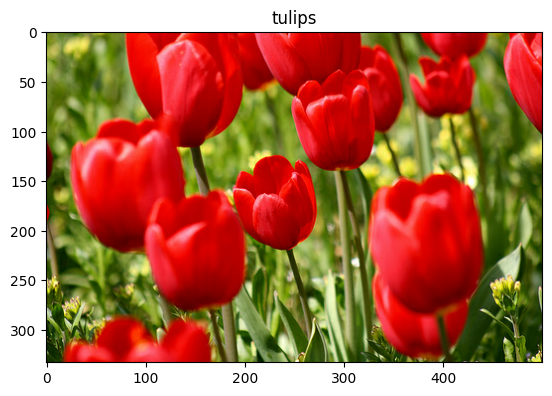

In [5]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

## Keras 前処理レイヤーを使用する

### リサイズとリスケール


Keras 前処理レイヤーを使用して、画像を一定の形状にサイズ変更し（`tf.keras.layers.Resizing`）、ピクセル値を再スケールする（`tf.keras.layers.Rescaling`）ことができます。

In [6]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

注意: 上記のリスケーリングレイヤーは、ピクセル値を `[0,1]` の範囲に標準化します。代わりに `[-1,1]` を用いる場合には、`tf.keras.layers.Rescaling(1./127.5, offset=-1)` と記述します。


次のようにして、これらのレイヤーを画像に適用した結果を可視化します。 

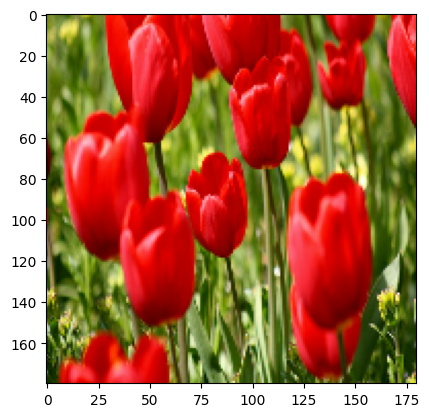

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result)

ピクセルが `[0, 1]` の範囲にあることを確認します。

In [8]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


### データ増強

`tf.keras.layers.RandomFlip` や `tf.keras.layers.RandomRotation` などの Keras 前処理レイヤーをデータ拡張に使用することができます。

前処理レイヤーをいくつか作成し、同じ画像に繰り返して適用してみましょう。

In [9]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [10]:
# Add the image to a batch.
image = tf.cast(tf.expand_dims(image, 0), tf.float32)

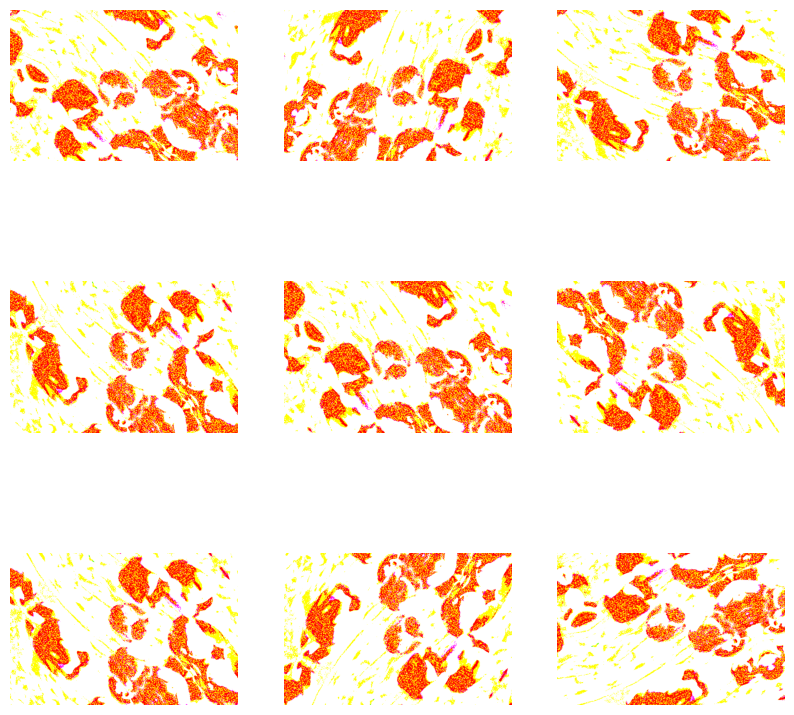

In [11]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

データ拡張には、`tf.keras.layers.RandomContrast`、`tf.keras.layers.RandomCrop`、`tf.keras.layers.RandomZoom` など、様々な前処理レイヤーを使用できます。

### Keras 前処理レイヤーを使用するための 2 つのオプション

これらの前処理レイヤーを使用できる方法には 2 つありませうが、これらには重要なトレードオフが伴います。

#### オプション 1: 前処理レイヤーをモデルの一部にする

In [12]:
model = tf.keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # Rest of your model.
])

この場合、2 つの重要なポイントがあります。

- データ増強はデバイス上で他のレイヤーと同期して実行されるため、GPU アクセラレーションの恩恵を受けることができます。

- `model.save`を使用してモデルをエクスポートすると、前処理レイヤーはモデルの残りの部分と一緒に保存されます。後でこのモデルをデプロイする場合、画像は自動的に（レイヤーの設定に従い）標準化されます。これにより、サーバーサイドでロジックを再実装する手間が省けます。

注意: データ拡張はテスト時には非アクティブなので、(`Model.evaluate` や `Model.predict` ではなく)  `Model.fit` への呼び出し時にのみ、入力画像を拡張します。

#### オプション 2: 前処理レイヤーをデータセットに適用する

In [13]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

このアプローチでは、`Dataset.map` を使用して、拡張画像のバッチを生成するデータセットを作成します。この場合は、

- データ拡張は CPU 上で非同期に行われ、ノンブロッキングです。以下に示すように、`Dataset.prefetch` を使用して GPU 上でのモデルのトレーニングをデータの前処理にオーバーラップさせることができます。
- この場合、`Model.save` を呼び出しても、前処理レイヤーはモデルと一緒にエクスポートされません。保存前にモデルに前処理レイヤーをアタッチするか、サーバー側で前処理レイヤーを再実装する必要があります。トレーニングの後、エクスポートする前に前処理レイヤーをアタッチすることができます。


1 番目のオプションの例については、[画像分類](classification.ipynb)チュートリアルをご覧ください。次に、2 番目のオプションを見てみましょう。

### 前処理レイヤーをデータセットに適用する

前に作成した前処理レイヤーを使用して、トレーニング、検証、テスト用のデータセットを構成します。また、パフォーマンス向上のために、並列読み取りとバッファ付きプリフェッチを使用してデータセットを構成し、I/O がブロックされることなくディスクからバッチを生成できるようにします。（データセットのパフォーマンスに関する詳細は、[tf.data API によるパフォーマンス向上](https://www.tensorflow.org/guide/data_performance)ガイドをご覧ください。）

注意: データ拡張はトレーニングセットのみに適用されます。

In [14]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

### モデルをトレーニングする

完全を期すために、準備したデータセットを使用してモデルをトレーニングします。

[Sequential](https://www.tensorflow.org/guide/keras/sequential_model) モデルは、それぞれに最大プールレイヤー（`tf.keras.layers.MaxPooling2D`）を持つ3つの畳み込みブロック（`tf.keras.layers.Conv2D`）で構成されます。ReLU 活性化関数（`'relu'`）により活性化されたユニットが 128 個ある完全に接続されたレイヤー（`tf.keras.layers.Dense`）があります。このモデルの精度は調整されていません（このチュートリアルの目的は、標準的なアプローチを示すことであるため）。

In [16]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

`tf.keras.optimizers.Adam` オプティマイザと`tf.keras.losses.SparseCategoricalCrossentropy` 損失関数を選択します。各トレーニングエポックのトレーニングと検証の精度を表示するには、`Model.compile` に `metrics` 引数を渡します。

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

数エポック、トレーニングします。

In [18]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5


I0000 00:00:1705011632.174898 1015219 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 1/92 [..............................] - ETA: 7:03 - loss: 1.6241 - accuracy: 0.0938

 4/92 [>.............................] - ETA: 1s - loss: 2.4370 - accuracy: 0.2422  

 7/92 [=>............................] - ETA: 1s - loss: 2.1108 - accuracy: 0.2098

10/92 [==>...........................] - ETA: 1s - loss: 1.9530 - accuracy: 0.2125

13/92 [===>..........................] - ETA: 1s - loss: 1.8624 - accuracy: 0.2308

16/92 [====>.........................] - ETA: 1s - loss: 1.8114 - accuracy: 0.2285

19/92 [=====>........................] - ETA: 1s - loss: 1.7645 - accuracy: 0.2582

22/92 [======>.......................] - ETA: 1s - loss: 1.7311 - accuracy: 0.2727

25/92 [=======>......................] - ETA: 1s - loss: 1.6992 - accuracy: 0.2775

28/92 [========>.....................] - ETA: 1s - loss: 1.6725 - accuracy: 0.2913

31/92 [=========>....................] - ETA: 1s - loss: 1.6583 - accuracy: 0.2974

34/92 [==========>...................] - ETA: 1s - loss: 1.6315 - accuracy: 0.2987

37/92 [===========>..................] - ETA: 1s - loss: 1.6030 - accuracy: 0.3142

40/92 [============>.................] - ETA: 1s - loss: 1.5766 - accuracy: 0.3258

43/92 [=============>................] - ETA: 1s - loss: 1.5563 - accuracy: 0.3314

46/92 [==============>...............] - ETA: 0s - loss: 1.5363 - accuracy: 0.3342

49/92 [==============>...............] - ETA: 0s - loss: 1.5145 - accuracy: 0.3412

52/92 [===============>..............] - ETA: 0s - loss: 1.4983 - accuracy: 0.3450

55/92 [================>.............] - ETA: 0s - loss: 1.4832 - accuracy: 0.3540

58/92 [=================>............] - ETA: 0s - loss: 1.4720 - accuracy: 0.3588

61/92 [==================>...........] - ETA: 0s - loss: 1.4644 - accuracy: 0.3642

64/92 [===================>..........] - ETA: 0s - loss: 1.4524 - accuracy: 0.3701

67/92 [====================>.........] - ETA: 0s - loss: 1.4458 - accuracy: 0.3736

70/92 [=====================>........] - ETA: 0s - loss: 1.4351 - accuracy: 0.3777

73/92 [======================>.......] - ETA: 0s - loss: 1.4266 - accuracy: 0.3810

76/92 [=======================>......] - ETA: 0s - loss: 1.4137 - accuracy: 0.3869

79/92 [========================>.....] - ETA: 0s - loss: 1.4073 - accuracy: 0.3912

82/92 [=========================>....] - ETA: 0s - loss: 1.3976 - accuracy: 0.3925

85/92 [==========================>...] - ETA: 0s - loss: 1.3885 - accuracy: 0.3960

88/92 [===========================>..] - ETA: 0s - loss: 1.3753 - accuracy: 0.4013

91/92 [============================>.] - ETA: 0s - loss: 1.3667 - accuracy: 0.4052

92/92 [==============================] - ETA: 0s - loss: 1.3657 - accuracy: 0.4067

92/92 [==============================] - 9s 46ms/step - loss: 1.3657 - accuracy: 0.4067 - val_loss: 1.1159 - val_accuracy: 0.5531


Epoch 2/5


 1/92 [..............................] - ETA: 29s - loss: 1.1856 - accuracy: 0.4375

 4/92 [>.............................] - ETA: 1s - loss: 1.1611 - accuracy: 0.5391 

 7/92 [=>............................] - ETA: 1s - loss: 1.1178 - accuracy: 0.5402

10/92 [==>...........................] - ETA: 1s - loss: 1.1514 - accuracy: 0.5063

13/92 [===>..........................] - ETA: 1s - loss: 1.1602 - accuracy: 0.5072

16/92 [====>.........................] - ETA: 1s - loss: 1.1644 - accuracy: 0.5098

19/92 [=====>........................] - ETA: 1s - loss: 1.1415 - accuracy: 0.5280

22/92 [======>.......................] - ETA: 1s - loss: 1.1319 - accuracy: 0.5284

25/92 [=======>......................] - ETA: 1s - loss: 1.1299 - accuracy: 0.5250

28/92 [========>.....................] - ETA: 1s - loss: 1.1241 - accuracy: 0.5179

31/92 [=========>....................] - ETA: 1s - loss: 1.1277 - accuracy: 0.5252

34/92 [==========>...................] - ETA: 1s - loss: 1.1334 - accuracy: 0.5230

37/92 [===========>..................] - ETA: 1s - loss: 1.1344 - accuracy: 0.5228

40/92 [============>.................] - ETA: 1s - loss: 1.1327 - accuracy: 0.5281

43/92 [=============>................] - ETA: 1s - loss: 1.1299 - accuracy: 0.5327

46/92 [==============>...............] - ETA: 0s - loss: 1.1272 - accuracy: 0.5312

49/92 [==============>...............] - ETA: 0s - loss: 1.1210 - accuracy: 0.5319

52/92 [===============>..............] - ETA: 0s - loss: 1.1179 - accuracy: 0.5319

55/92 [================>.............] - ETA: 0s - loss: 1.1159 - accuracy: 0.5324

58/92 [=================>............] - ETA: 0s - loss: 1.1167 - accuracy: 0.5329

61/92 [==================>...........] - ETA: 0s - loss: 1.1061 - accuracy: 0.5430

64/92 [===================>..........] - ETA: 0s - loss: 1.1013 - accuracy: 0.5444

67/92 [====================>.........] - ETA: 0s - loss: 1.0957 - accuracy: 0.5490

70/92 [=====================>........] - ETA: 0s - loss: 1.0871 - accuracy: 0.5527

73/92 [======================>.......] - ETA: 0s - loss: 1.0919 - accuracy: 0.5522

76/92 [=======================>......] - ETA: 0s - loss: 1.0950 - accuracy: 0.5518

79/92 [========================>.....] - ETA: 0s - loss: 1.0906 - accuracy: 0.5546

82/92 [=========================>....] - ETA: 0s - loss: 1.0815 - accuracy: 0.5587

85/92 [==========================>...] - ETA: 0s - loss: 1.0791 - accuracy: 0.5614

88/92 [===========================>..] - ETA: 0s - loss: 1.0734 - accuracy: 0.5632

91/92 [============================>.] - ETA: 0s - loss: 1.0747 - accuracy: 0.5646

92/92 [==============================] - 2s 21ms/step - loss: 1.0734 - accuracy: 0.5654 - val_loss: 0.9760 - val_accuracy: 0.6567


Epoch 3/5


 1/92 [..............................] - ETA: 25s - loss: 1.2470 - accuracy: 0.5312

 4/92 [>.............................] - ETA: 2s - loss: 1.1092 - accuracy: 0.5703 

 7/92 [=>............................] - ETA: 1s - loss: 1.0780 - accuracy: 0.5804

10/92 [==>...........................] - ETA: 1s - loss: 1.0758 - accuracy: 0.5750

13/92 [===>..........................] - ETA: 1s - loss: 1.0678 - accuracy: 0.5745

16/92 [====>.........................] - ETA: 1s - loss: 1.0290 - accuracy: 0.6016

19/92 [=====>........................] - ETA: 1s - loss: 1.0356 - accuracy: 0.5987

22/92 [======>.......................] - ETA: 1s - loss: 1.0219 - accuracy: 0.6051

25/92 [=======>......................] - ETA: 1s - loss: 1.0195 - accuracy: 0.6037

28/92 [========>.....................] - ETA: 1s - loss: 1.0217 - accuracy: 0.6027

31/92 [=========>....................] - ETA: 1s - loss: 1.0160 - accuracy: 0.6069

34/92 [==========>...................] - ETA: 1s - loss: 1.0062 - accuracy: 0.6075

37/92 [===========>..................] - ETA: 1s - loss: 0.9986 - accuracy: 0.6098

40/92 [============>.................] - ETA: 1s - loss: 1.0062 - accuracy: 0.6039

43/92 [=============>................] - ETA: 1s - loss: 1.0128 - accuracy: 0.6039

46/92 [==============>...............] - ETA: 0s - loss: 1.0062 - accuracy: 0.6073

49/92 [==============>...............] - ETA: 0s - loss: 0.9976 - accuracy: 0.6091

52/92 [===============>..............] - ETA: 0s - loss: 0.9950 - accuracy: 0.6100

55/92 [================>.............] - ETA: 0s - loss: 0.9873 - accuracy: 0.6114

58/92 [=================>............] - ETA: 0s - loss: 0.9801 - accuracy: 0.6137

61/92 [==================>...........] - ETA: 0s - loss: 0.9770 - accuracy: 0.6122

64/92 [===================>..........] - ETA: 0s - loss: 0.9719 - accuracy: 0.6147

67/92 [====================>.........] - ETA: 0s - loss: 0.9722 - accuracy: 0.6138

70/92 [=====================>........] - ETA: 0s - loss: 0.9714 - accuracy: 0.6112

73/92 [======================>.......] - ETA: 0s - loss: 0.9736 - accuracy: 0.6096

76/92 [=======================>......] - ETA: 0s - loss: 0.9794 - accuracy: 0.6065

79/92 [========================>.....] - ETA: 0s - loss: 0.9824 - accuracy: 0.6072

82/92 [=========================>....] - ETA: 0s - loss: 0.9858 - accuracy: 0.6044

85/92 [==========================>...] - ETA: 0s - loss: 0.9863 - accuracy: 0.6048

88/92 [===========================>..] - ETA: 0s - loss: 0.9798 - accuracy: 0.6083

91/92 [============================>.] - ETA: 0s - loss: 0.9789 - accuracy: 0.6092

92/92 [==============================] - 2s 21ms/step - loss: 0.9780 - accuracy: 0.6097 - val_loss: 1.0353 - val_accuracy: 0.5749


Epoch 4/5


 1/92 [..............................] - ETA: 27s - loss: 1.0990 - accuracy: 0.6250

 4/92 [>.............................] - ETA: 1s - loss: 0.9103 - accuracy: 0.6641 

 7/92 [=>............................] - ETA: 1s - loss: 0.8809 - accuracy: 0.6830

10/92 [==>...........................] - ETA: 1s - loss: 0.9436 - accuracy: 0.6469

13/92 [===>..........................] - ETA: 1s - loss: 0.9325 - accuracy: 0.6322

16/92 [====>.........................] - ETA: 1s - loss: 0.9405 - accuracy: 0.6348

19/92 [=====>........................] - ETA: 1s - loss: 0.9607 - accuracy: 0.6316

22/92 [======>.......................] - ETA: 1s - loss: 0.9529 - accuracy: 0.6236

25/92 [=======>......................] - ETA: 1s - loss: 0.9428 - accuracy: 0.6275

28/92 [========>.....................] - ETA: 1s - loss: 0.9353 - accuracy: 0.6250

31/92 [=========>....................] - ETA: 1s - loss: 0.9395 - accuracy: 0.6250

34/92 [==========>...................] - ETA: 1s - loss: 0.9365 - accuracy: 0.6213

37/92 [===========>..................] - ETA: 1s - loss: 0.9341 - accuracy: 0.6242

40/92 [============>.................] - ETA: 1s - loss: 0.9322 - accuracy: 0.6227

43/92 [=============>................] - ETA: 1s - loss: 0.9301 - accuracy: 0.6243

46/92 [==============>...............] - ETA: 0s - loss: 0.9283 - accuracy: 0.6243

49/92 [==============>...............] - ETA: 0s - loss: 0.9230 - accuracy: 0.6250

52/92 [===============>..............] - ETA: 0s - loss: 0.9198 - accuracy: 0.6250

55/92 [================>.............] - ETA: 0s - loss: 0.9197 - accuracy: 0.6239

58/92 [=================>............] - ETA: 0s - loss: 0.9169 - accuracy: 0.6261

61/92 [==================>...........] - ETA: 0s - loss: 0.9156 - accuracy: 0.6276

64/92 [===================>..........] - ETA: 0s - loss: 0.9217 - accuracy: 0.6245

67/92 [====================>.........] - ETA: 0s - loss: 0.9258 - accuracy: 0.6213

70/92 [=====================>........] - ETA: 0s - loss: 0.9249 - accuracy: 0.6228

73/92 [======================>.......] - ETA: 0s - loss: 0.9241 - accuracy: 0.6233

76/92 [=======================>......] - ETA: 0s - loss: 0.9201 - accuracy: 0.6246

79/92 [========================>.....] - ETA: 0s - loss: 0.9151 - accuracy: 0.6250

82/92 [=========================>....] - ETA: 0s - loss: 0.9168 - accuracy: 0.6242

85/92 [==========================>...] - ETA: 0s - loss: 0.9125 - accuracy: 0.6261

88/92 [===========================>..] - ETA: 0s - loss: 0.9063 - accuracy: 0.6310

91/92 [============================>.] - ETA: 0s - loss: 0.9045 - accuracy: 0.6326

92/92 [==============================] - 2s 21ms/step - loss: 0.9035 - accuracy: 0.6339 - val_loss: 0.9541 - val_accuracy: 0.6349


Epoch 5/5


 1/92 [..............................] - ETA: 24s - loss: 0.8616 - accuracy: 0.7188

 3/92 [..............................] - ETA: 2s - loss: 0.8283 - accuracy: 0.7188 

 6/92 [>.............................] - ETA: 2s - loss: 0.9073 - accuracy: 0.6667

 9/92 [=>............................] - ETA: 2s - loss: 0.9582 - accuracy: 0.6354

12/92 [==>...........................] - ETA: 1s - loss: 0.9530 - accuracy: 0.6354

15/92 [===>..........................] - ETA: 1s - loss: 0.9303 - accuracy: 0.6354

18/92 [====>.........................] - ETA: 1s - loss: 0.8981 - accuracy: 0.6476

21/92 [=====>........................] - ETA: 1s - loss: 0.8802 - accuracy: 0.6592

24/92 [======>.......................] - ETA: 1s - loss: 0.8699 - accuracy: 0.6628

27/92 [=======>......................] - ETA: 1s - loss: 0.8806 - accuracy: 0.6562

30/92 [========>.....................] - ETA: 1s - loss: 0.8805 - accuracy: 0.6573

33/92 [=========>....................] - ETA: 1s - loss: 0.8746 - accuracy: 0.6610

36/92 [==========>...................] - ETA: 1s - loss: 0.8722 - accuracy: 0.6571

39/92 [===========>..................] - ETA: 1s - loss: 0.8794 - accuracy: 0.6530

42/92 [============>.................] - ETA: 1s - loss: 0.8775 - accuracy: 0.6548

45/92 [=============>................] - ETA: 0s - loss: 0.8720 - accuracy: 0.6535

48/92 [==============>...............] - ETA: 0s - loss: 0.8745 - accuracy: 0.6530

51/92 [===============>..............] - ETA: 0s - loss: 0.8727 - accuracy: 0.6562

54/92 [================>.............] - ETA: 0s - loss: 0.8773 - accuracy: 0.6545

57/92 [=================>............] - ETA: 0s - loss: 0.8839 - accuracy: 0.6491

60/92 [==================>...........] - ETA: 0s - loss: 0.8883 - accuracy: 0.6453

63/92 [===================>..........] - ETA: 0s - loss: 0.8894 - accuracy: 0.6409

66/92 [====================>.........] - ETA: 0s - loss: 0.8904 - accuracy: 0.6406

69/92 [=====================>........] - ETA: 0s - loss: 0.8955 - accuracy: 0.6359

72/92 [======================>.......] - ETA: 0s - loss: 0.8912 - accuracy: 0.6411

75/92 [=======================>......] - ETA: 0s - loss: 0.8857 - accuracy: 0.6467

78/92 [========================>.....] - ETA: 0s - loss: 0.8819 - accuracy: 0.6502

81/92 [=========================>....] - ETA: 0s - loss: 0.8776 - accuracy: 0.6532

84/92 [==========================>...] - ETA: 0s - loss: 0.8768 - accuracy: 0.6529

87/92 [===========================>..] - ETA: 0s - loss: 0.8757 - accuracy: 0.6523

90/92 [============================>.] - ETA: 0s - loss: 0.8737 - accuracy: 0.6531

92/92 [==============================] - 2s 21ms/step - loss: 0.8713 - accuracy: 0.6540 - val_loss: 0.9970 - val_accuracy: 0.6349


In [19]:
loss, acc = model.evaluate(test_ds)
print("Accuracy", acc)

 1/12 [=>............................] - ETA: 13s - loss: 1.0922 - accuracy: 0.5938

 9/12 [=====================>........] - ETA: 0s - loss: 1.0311 - accuracy: 0.5903 

12/12 [==============================] - 1s 7ms/step - loss: 0.9701 - accuracy: 0.6158


Accuracy 0.6158038377761841


### カスタムデータ増強

また、カスタムデータ拡張レイヤーを作成することもできます。

このセクションでは、これを行うための 2 つの方法を説明します。

- まず、`tf.keras.layers.Lambda` レイヤーを作成します。簡潔なコードを書くには良い方法です。
- 次に、[subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models) を介して新しいレイヤーを記述します。こうすることで、さらに制御できるようになります。

どちらのレイヤーも、確率に従って、画像の色をランダムに反転します。

In [20]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [21]:
def random_invert(factor=0.5):
  return layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

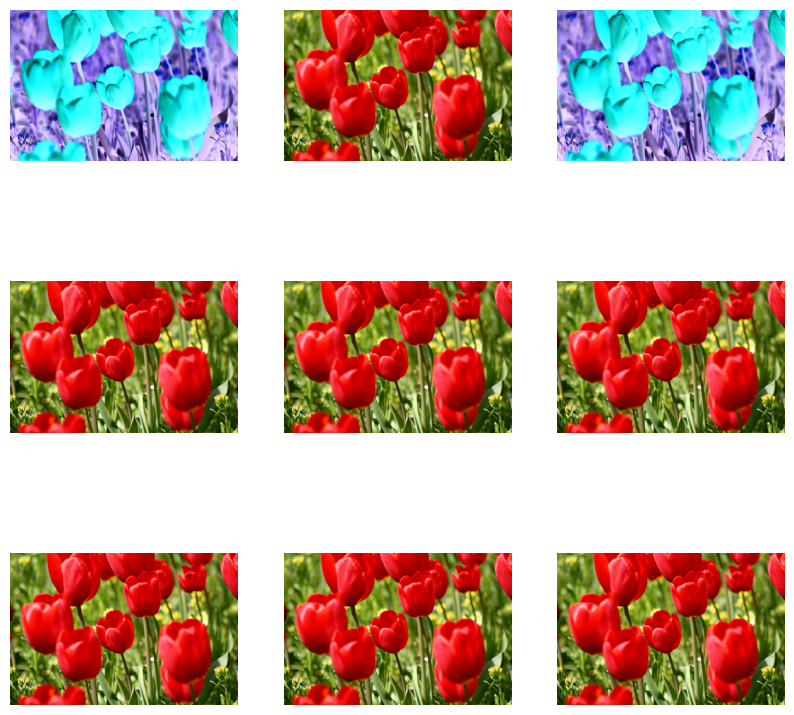

In [22]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

次に、[サブクラス化](https://www.tensorflow.org/guide/keras/custom_layers_and_models)してカスタムレイヤーを実装します。

In [23]:
class RandomInvert(layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

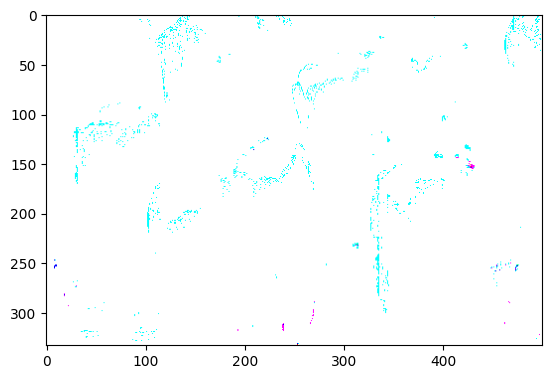

In [24]:
_ = plt.imshow(RandomInvert()(image)[0])

どちらのレイヤーも、上記 1 と 2 のオプションで説明した使用が可能です。

## tf.image を使用する

上記の Keras 前処理ユーティリティは便利ではありますが、より細かい制御には、`tf.data` や `tf.image` を使用して独自のデータ拡張パイプラインやレイヤーを書くことができます。（また、<a>TensorFlow Addons 画像: 演算</a>および [TensorFlow I/O: 色空間の変換](https://www.tensorflow.org/io/tutorials/colorspace)もご覧ください。）

花のデータセットは、前にデータ拡張で構成したので、再インポートして最初からやり直しましょう。

In [25]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

作業に必要な画像を取得します。

2024-01-11 22:20:51.328796: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


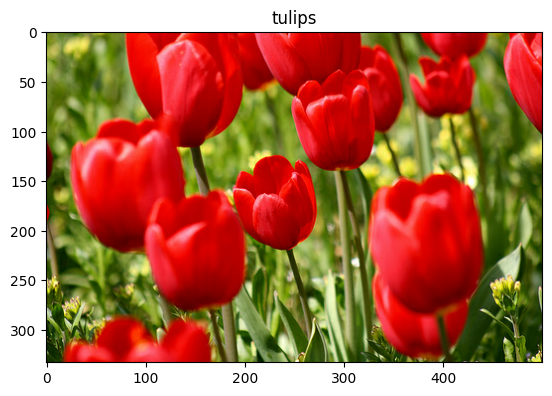

In [26]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

以下の関数を使用して元の画像と拡張画像を並べて視覚化し、比較してみましょう。

In [27]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

### データ増強

#### 画像をフリップする

`tf.image.flip_left_right` を使って、画像を縦方向または横方向に反転します。

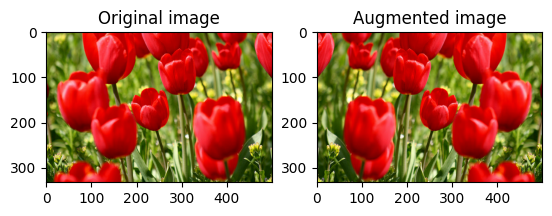

In [28]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

#### 画像をグレースケールにする

`tf.image.rgb_to_grayscale` を使って、画像をグレースケールにできます。

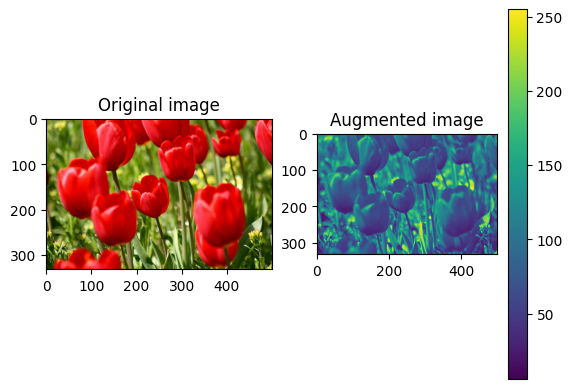

In [29]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image, tf.squeeze(grayscaled))
_ = plt.colorbar()

#### 画像の彩度を処理する

`tf.image.adjust_saturation` を使用し、彩度係数を指定して画像の彩度を操作します。

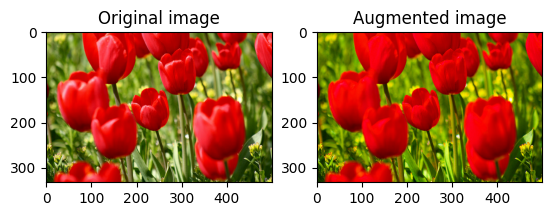

In [30]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

#### 画像の明るさを変更する

`tf.image.adjust_brightness` を使用し、明度係数を指定して画像の明度を変更します。

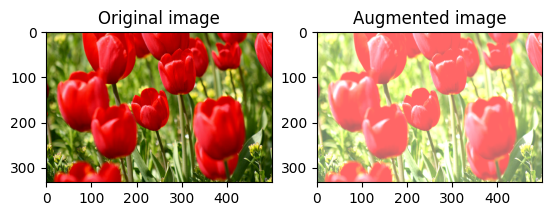

In [31]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

#### 画像を中央でトリミングする

`tf.image.central_crop` を使用して、画像の中央から希望する部分までをトリミングします。

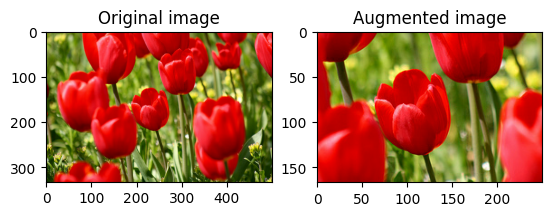

In [32]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

#### 画像を回転させる

`tf.image.rot90` を使用して、画像を 90 度回転させます。

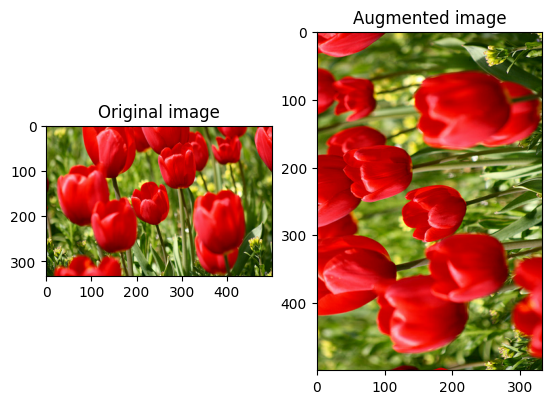

In [33]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

### ランダム変換

警告: ランダム画像演算には `tf.image.random*` および `tf.image.stateless_random*` の 2 つのセットがあります。`tf.image.random*` 演算は、TF 1.x の古い RNG を使用するため、使用することは強くお勧めしません。代わりに、このチュートリアルで紹介したランダム画像演算を使用してください。詳細については、[乱数の生成](../../guide/random_numbers.ipynb)を参照してください。

画像にランダムな変換を適用すると、データセットの一般化と拡張にさらに役立ちます。現在の `tf.image` は、次の 8 つのランダム画像演算 (ops) を提供します。

- [`tf.image.stateless_random_brightness`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_brightness)
- [`tf.image.stateless_random_contrast`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_contrast)
- [`tf.image.stateless_random_crop`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_crop)
- [`tf.image.stateless_random_flip_left_right`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_left_right)
- [`tf.image.stateless_random_flip_up_down`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_flip_up_down)
- [`tf.image.stateless_random_hue`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_hue)
- [`tf.image.stateless_random_jpeg_quality`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_jpeg_quality)
- [`tf.image.stateless_random_saturation`](https://www.tensorflow.org/api_docs/python/tf/image/stateless_random_saturation)

これらのランダム画像演算は機能的であり、出力は入力にのみ依存します。これにより、高性能で決定論的な入力パイプラインで簡単に使用できるようになります。各ステップで `seed` 値を入力する必要があります。同じ `seed`を指定すると、呼び出された回数に関係なく、同じ結果が返されます。

注意: `seed` は、形状が `(2,)`  の `Tensor` で、値は任意の整数です。

以降のセクションでは、次のことを行います。

1. ランダム画像演算を使用して画像を変換する例を見る。
2. ランダム変換をトレーニングデータセットに適用する方法を示す。

#### 画像の明るさをランダムに変更する

`tf.image.stateless_random_brightness` を使用し、明度係数と `seed` を指定して、`image` の明度をランダムに変更します。明度係数は、`[-max_delta, max_delta)` の範囲でランダムに選択され、指定された `seed` に関連付けられます。

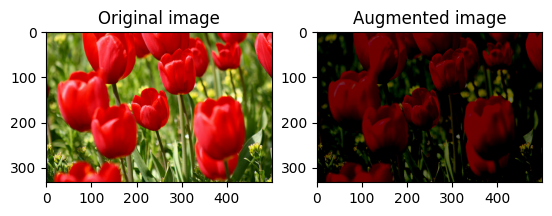

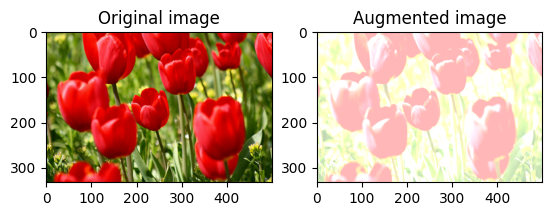

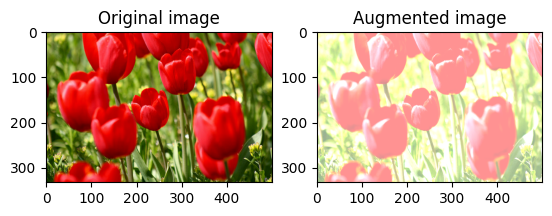

In [34]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

#### 画像のコントラストをランダムに変更する

`tf.image.stateless_random_contrast` を使用し、コントラスト範囲と `seed` を指定して、`image` のコントラストをランダムに変更します。コントラスト範囲は、`[lower, upper]` の間隔でランダムに選択され、指定された `seed` に関連付けられます。

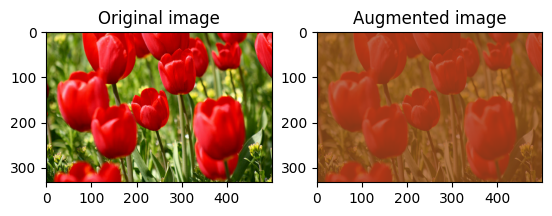

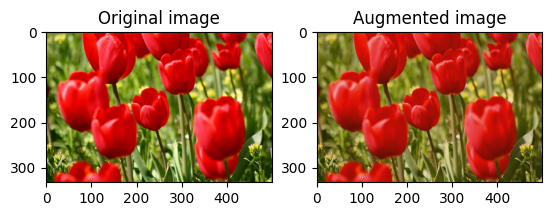

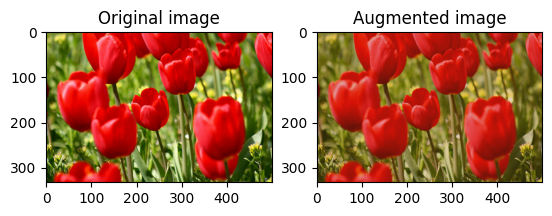

In [35]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_contrast = tf.image.stateless_random_contrast(
      image, lower=0.1, upper=0.9, seed=seed)
  visualize(image, stateless_random_contrast)

#### ランダムに画像をトリミングする

`tf.image.stateless_random_crop` を使用し、ターゲットの `size` と `seed` を指定して `image` をランダムにトリミングします。`image` から切り取られる部分は、ランダムに選択されたオフセットにあり、指定された `seed` に関連付けられています。

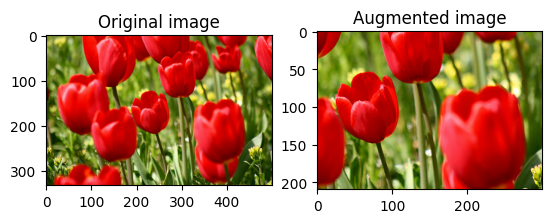

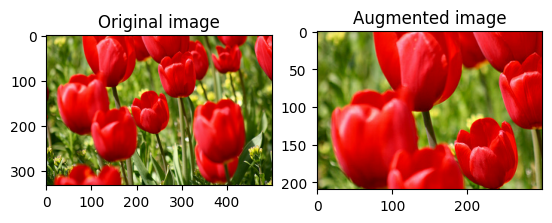

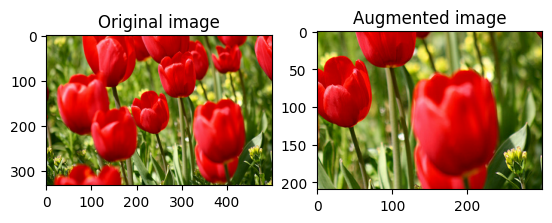

In [36]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_crop = tf.image.stateless_random_crop(
      image, size=[210, 300, 3], seed=seed)
  visualize(image, stateless_random_crop)

### データ増強をデータセットに適用する

前に説明したように、`Dataset.map` を使用してデータセットにデータ拡張を適用します。

In [37]:
(train_datasets, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

次に、画像のサイズ変更と再スケーリングのためのユーティリティ関数を定義します。この関数は、データセット内の画像のサイズとスケールを統一するために使用されます。

In [38]:
def resize_and_rescale(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  return image, label

また、画像にランダム変換を適用できる `augment` 関数も定義します。この関数は、次のステップのデータセットで使用されます。

In [39]:
def augment(image_label, seed):
  image, label = image_label
  image, label = resize_and_rescale(image, label)
  image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
  # Make a new seed.
  new_seed = tf.random.split(seed, num=1)[0, :]
  # Random crop back to the original size.
  image = tf.image.stateless_random_crop(
      image, size=[IMG_SIZE, IMG_SIZE, 3], seed=seed)
  # Random brightness.
  image = tf.image.stateless_random_brightness(
      image, max_delta=0.5, seed=new_seed)
  image = tf.clip_by_value(image, 0, 1)
  return image, label

#### オプション 1: tf.data.experimental.Counte を使用する

`tf.data.experimental.Counter` オブジェクト (`counter` と呼ぶ) を作成し、`(counter, counter)` を含むデータセットを `zip` します。これにより、データセット内の各画像が、`counter` に基づいて（一意の値形状 `(2,)`）に関連付けられるようになります。これは後で、ランダム変換の `seed` 値として `augment` 関数に渡されます。

In [40]:
# Create a `Counter` object and `Dataset.zip` it together with the training set.
counter = tf.data.experimental.Counter()
train_ds = tf.data.Dataset.zip((train_datasets, (counter, counter)))

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


`augment` 関数をトレーニングデータセットにマッピングします。

In [41]:
train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [42]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [43]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

#### オプション 2: `tf.random.Generator` を使用する

- `seed` の初期値で `tf.random.Generator` オブジェクトを作成します。同じジェネレータオブジェクトに `make_seeds` 関数を呼び出すと、必ず新しい一意の `seed` 値が返されます。
- ラッパー関数を 1) `make_seeds` 関数を呼び出し、2) 新たに生成された `seed` 値を `augment` 関数に渡してランダム変換を行うように定義します。

注意: `tf.random.Generator` オブジェクトは RNG 状態を `tf.Variable` に格納するため、[checkpoint](../../guide/checkpoint.ipynb) または  [SavedModel](../../guide/saved_model.ipynb) として保存できます。詳細につきましては、[乱数の生成](../../guide/random_numbers.ipynb)を参照してください。

In [44]:
# Create a generator.
rng = tf.random.Generator.from_seed(123, alg='philox')

In [45]:
# Create a wrapper function for updating seeds.
def f(x, y):
  seed = rng.make_seeds(2)[0]
  image, label = augment((x, y), seed)
  return image, label

ラッパー関数 `f` をトレーニングデータセットにマッピングし、`resize_and_rescale` 関数を検証セットとテストセットにマッピングします。

In [46]:
train_ds = (
    train_datasets
    .shuffle(1000)
    .map(f, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [47]:
val_ds = (
    val_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

In [48]:
test_ds = (
    test_ds
    .map(resize_and_rescale, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

前に示したように、これらのデータセットはモデルのトレーニングに使用が可能です。

## 次のステップ

このチュートリアルでは、Keras 前処理レイヤーと `tf.image` を使用したデータ拡張を説明しました。

- モデル内に前処理レイヤーを含める方法については、[画像の分類](classification.ipynb)チュートリアルをご覧ください。
- 前処理レイヤーでテキストを分類する方法にも関心がある場合は、[基本的なテキスト分類](../keras/text_classification.ipynb)チュートリアルをご覧ください。
- `tf.data` については、こちらの[ガイド](../../guide/data.ipynb)でもさらに詳しく学習できます。パフォーマンスを向上させる入力パイプラインの構成方法については、[こちら](../../guide/data_performance.ipynb)をご覧ください。